In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats
import math
import pickle
from sklearn.utils import resample
from sklearn.utils import shuffle

# Train-Test
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import StandardScaler

# Normalization
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer



In [2]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary
    
def transform_outliers(df, norm_col, threshold_capped=1.5, threshold_trimmed=1.8,  test_mode=False, limits={},
                        use_manual_limits=False, upper_limit_trim=0, lower_limit_trim=0, upper_limit_cap=0, lower_limit_cap=0, print_output=False):
    
    outliers_limits={}
    # Trimming and capping outliers
    outliers_total = np.array(np.repeat(False,df.shape[0]))
    df_capped = df.copy()
    for col in norm_col:
        
        if not test_mode:
            outliers_limits_col={}
            if use_manual_limits:
                upper_limit, lower_limit = upper_limit_trim, lower_limit_trim
            else:
                upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_trimmed)

            outliers_limits_col['upper_limit_trim'] = upper_limit
            outliers_limits_col['lower_limit_trim'] = lower_limit
        else:
            upper_limit, lower_limit = limits[col]['upper_limit_trim'], limits[col]['lower_limit_trim']

        outliers = np.where(df[col] > upper_limit, True,
                            np.where(df[col] < lower_limit, True, False))                        
        outliers_total = np.logical_or(outliers_total, outliers)
        
        if print_output:
            print(str(col) + " outliers = "+str(outliers.sum()))
        
        if not test_mode:
            if use_manual_limits:
                upper_limit, lower_limit = upper_limit_cap, lower_limit_cap
            else:
                upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_capped)

            outliers_limits_col['upper_limit_cap'] = upper_limit
            outliers_limits_col['lower_limit_cap'] = lower_limit
            outliers_limits[col] = outliers_limits_col
        else:
            upper_limit, lower_limit = limits[col]['upper_limit_cap'], limits[col]['lower_limit_cap']

        df_capped[col] = np.where(df[col] > upper_limit, upper_limit,
                            np.where(df[col] < lower_limit, lower_limit, df_capped[col]))

    if print_output:
        print("Total outliers = "+str(outliers_total.sum()))
        
    df_trimmed = df_capped.loc[~(outliers_total)]
    
    if not test_mode:
        return df_trimmed, outliers_limits
    else:
        return df_trimmed

label
1    606
0    298
Name: count, dtype: int64
X_train.shape, X_test.shape = 
(768, 13) (136, 13)
% of label in original dataset: 67.03539823008849
% of label in y_train: 67.05729166666666
% of label in y_test: 66.91176470588235


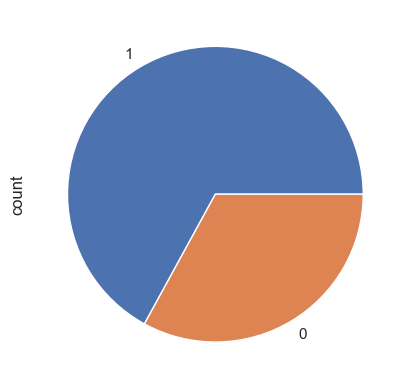

In [3]:
df = pd.read_csv('data_playlist.csv')
df = df[df['label'].notna()]

df_upsampled = resample(df[df['label']==1], replace = True, 
                            n_samples = df.label.value_counts().max()-df.label.value_counts().min()) 

df = pd.concat([df, df_upsampled]) 
df = shuffle(df)

df.label.value_counts().plot(kind ='pie')
print(df.label.value_counts())

y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['label'], axis=1),
    y,
    test_size=0.15,
    random_state=0,
    stratify=y
    )
    
print("X_train.shape, X_test.shape = ")
print(X_train.shape, X_test.shape)

print("% of label in original dataset: "+str((df['label']==1).sum()/df.shape[0]*100))
print("% of label in y_train: "+str((y_train==1).sum()/y_train.shape[0]*100))
print("% of label in y_test: "+str((y_test==1).sum()/y_test.shape[0]*100))

df_train = X_train.copy()
df_train['label']=y_train

df_test = X_test.copy()
df_test['label']=y_test

In [4]:
def pre_process_df(df, test_mode=False, param_dict={}, scale=True):

    if test_mode and not param_dict:
        raise Exception('param_list need for test mode')

    df_ = df.copy()

    # Outliers
    norm_col = ['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness','liveness', 'loudness', 'speechiness', 'tempo', 'valence','key', 'mode', 'time_signature']

    if not test_mode:
        df_, outliers_limits_ = transform_outliers(df_, norm_col)
    else:
        df_ = transform_outliers(df_, norm_col, test_mode=test_mode, limits=param_dict['outliers_limits'])
    
    # Scaling - General
    scaled_columns = ['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness','liveness', 'loudness', 'speechiness', 'tempo', 'valence','key', 'mode', 'time_signature']
    if scale:
        if not test_mode:
            scaler_ = StandardScaler()
            scaler_.fit(df_[scaled_columns])
        else:
            scaler_ = param_dict['scaler']
            
        df_[scaled_columns] = scaler_.transform(df_[scaled_columns])
    else:
        if not test_mode:
            scaler_ = None

    # Normalization
    norm_col_yj = ['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness','liveness', 'loudness', 'speechiness', 'tempo', 'valence','key', 'mode', 'time_signature']
    
    if not test_mode:
        power_yj_ = PowerTransformer(method= 'yeo-johnson')
        power_yj_.fit(df_[norm_col_yj])
    else:
        power_yj_ = param_dict['power_yj']
                
    df_[norm_col_yj] = power_yj_.transform(df_[norm_col_yj])

    if not test_mode:
        param_dict={'outliers_limits': outliers_limits_, 
                'scaler': scaler_, 
                'power_yj': power_yj_
        }
        return df_, param_dict

    return df_

In [5]:
df_train_processed, param_dict = pre_process_df(df_train)
df_test_processed = pre_process_df(df_test, test_mode=True, param_dict=param_dict)

df_train_processed_not_scaled, param_dict_not_scaled = pre_process_df(df_train, scale=False)
df_test_processed_not_scaled = pre_process_df(df_test, test_mode=True, param_dict=param_dict, scale=False)

In [7]:
# Scaled
df_train_processed.to_pickle('./data/df_train_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "wb")
pickle.dump(param_dict, open_file)
open_file.close()

df_test_processed.to_pickle('./data/df_test_processed.pkl')


# Not scaled
df_train_processed_not_scaled.to_pickle('./data/df_train_processed_not_scaled.pkl')

open_file = open('./data/df_param_dict_not_scaled.pkl', "wb")
pickle.dump(param_dict_not_scaled, open_file)
open_file.close()

df_test_processed_not_scaled.to_pickle('./data/df_test_processed_not_scaled.pkl')